In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import numba
from PIL import Image

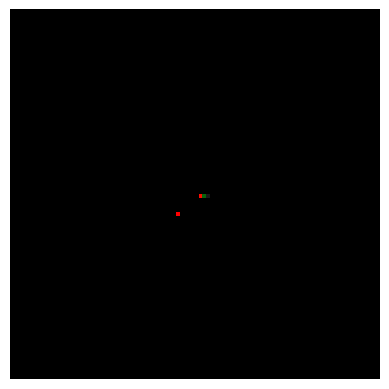

In [2]:
class Canvas():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.pixels = np.zeros((y,x,3),dtype=int)

    def _center2pixel(self, x, y):
        return (self.y//2 - y, self.x//2 + x)

    def write_pixel(self, x, y, color):
        x,y = self._center2pixel(x,y)
        self.pixels[x,y] = color.astype(int)

    def show(self):
        plt.imshow(self.pixels, vmin=0, vmax=255)
        plt.gca().axis('off')
        plt.show()

    
canvas = Canvas(100,100)


canvas.write_pixel(-5,-5,np.array([255,0,0]))
canvas.write_pixel(1,0,np.array([255,10,0]))
canvas.write_pixel(2,0,np.array([10,100,10]))
canvas.write_pixel(3,0,np.array([25.5,25.5,25.5]))
canvas.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


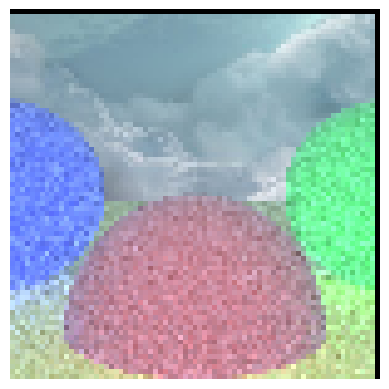

In [16]:
class Camera():
    def __init__(self, position=(0,0,0), orientation=[[1,0,0],[0,1,0],[0,0,1]], d=1, w=1, h=1, resolution=(100,100)):
        self.position = np.array(position)
        self.orientation = np.array(orientation)
        # distance from camera to canvas
        self.d = d

        # width and height of camera frame otherwise known as the FoV
        self.w = w
        self.h = h

        self.resolution = resolution

        if not resolution[1]/self.resolution[0] == h/w:
            raise "Resolution does not match aspect ratio"

        
        self.canvas = Canvas(*resolution)

    def canvas_to_world(self, x, y):
        return (x*self.w/self.resolution[0], y*self.h/self.resolution[1], self.d)

class Ray():
    def __init__(self, origin, direction, tmin=1, tmax=np.inf):
        self.origin = np.array(origin)
        self.direction = np.array(direction)

        self.tmin = tmin
        self.tmax = tmax

    def p(self, t):
        return self.origin + t*self.direction
    
class PointLight():
    def __init__(self, position, intensity):
        self.position = np.array(position)
        self.intensity = intensity

    def get_L(self, P):
        return self.position - P
        

class DirectionalLight():
    def __init__(self, position, direction, intensity):
        self.position = np.array(position)
        self.direction = np.array(direction)
        self.intensity = intensity
    
    def get_L(self, P):
        return self.direction


class PhongMaterial():
    def __init__(self, color, ambient=0.4, specular=0.9, reflective=0.2):
        self.color = np.array(color)
        self.ambient = ambient
        self.specular = specular
        self.reflective = reflective




class Sphere():
    def __init__(self, position=(0,0,5), radius=1, material=PhongMaterial((255,255,255))):
        self.position = np.array(position)
        self.radius = np.array(radius)
        self.material = material

    def intersect(self, ray):
        a = np.dot(ray.direction, ray.direction)
        b = 2*np.dot(ray.origin-self.position, ray.direction)
        c = np.dot(ray.origin-self.position, ray.origin-self.position) - self.radius**2

        discriminant = b**2 - 4*a*c

        if discriminant < 0:
            return [np.inf]
        else:
            t1 = (-b - np.sqrt(discriminant))/(2*a)
            t2 = (-b + np.sqrt(discriminant))/(2*a)
            return [t1,t2]

    def normal(self, point):
        # return normalized normal vector. 
        return (point-self.position)/self.radius



def closest_intersection(ray, objects):
    closest_object = None
    closest_t = np.inf
    for obj in objects:
        ts = obj.intersect(ray)
        for t in ts:
            if ray.tmin<=t<=ray.tmax:
                if t<closest_t:
                    closest_object = obj
                    closest_t = t
    return closest_object, closest_t



def hemisphere_to_world(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.cos(theta)
    z = np.sin(theta)*np.sin(phi)
    return np.array([x,y,z])

def sample_uniform_hemisphere(r1=None, r2=None, polar=False):
    # r1,r2 uniform random variables from 0 to 1
    # returns a vector in the hemisphere
    if not r1:
        r1 = np.random.uniform(0,1)
    if not r2:
        r2 = np.random.uniform(0,1)

    sin_theta = np.sqrt(1-r1**2)
    phi = 2*np.pi*r2

    x = sin_theta*np.cos(phi)
    y = r1 # cos(theta)
    z = sin_theta*np.sin(phi)

    if polar:
        return np.arcsin(sin_theta), phi
    else:
        return np.array([x,y,z])


def create_local_coordinate_system(N):
    # N is the normal vector
    # Nt is the tangent vector
    # Nb is the bitangent vector
    # N is the normal vector

    if (N[0]>N[1]):
        Nt = np.array([N[2], 0, -N[0]]) / np.linalg.norm(N)
    else:
        Nt = np.array([0, -N[2], N[1]]) / np.linalg.norm(N)
    Nb = np.cross(N,Nt)

    return np.array([Nt,Nb,N])


def local2world(P_local, N_world):
    Nt, Nb, _ = create_local_coordinate_system(N_world)

    A = np.array([[Nb[0], N_world[0], Nt[0]],
                  [Nb[1], N_world[1], Nt[1]],
                  [Nb[2], N_world[2], Nt[2]]])

    return A@P_local





class SkyBox():
    def __init__(self, image):
        self.image = np.array(image)
        self.split_cubemap()
    
    def split_cubemap(self):
        height, total_width, _ = self.image.shape
        face_width = total_width // 4

        images = [
                self.image[face_width:2*face_width, 2*face_width:3*face_width], # POSITIVE X
                self.image[face_width:2*face_width, 0:face_width], # NEGATIVE X
                self.image[0:face_width, face_width:2*face_width], # POSITIVE Y
                self.image[2*face_width:3*face_width, face_width:2*face_width], # NEGATIVE Y
                self.image[face_width:2*face_width, face_width:2*face_width], # POSITIVE Z
                self.image[face_width:2*face_width, 3*face_width:4*face_width], # NEGATIVE Z
                ]
        
        self.images = images
        return self.images

    def sphere2pixel(self, P):
        x,y,z = P
        abs_x, abs_y, abs_z = np.abs(P)

        x_positive = x>0
        y_positive = y>0
        z_positive = z>0

        # POSITIVE X
        if x_positive and abs_x >= abs_y and abs_x >= abs_z:
            max_axis = abs_x
            uc = -z
            vc = y
            index = 0

        # NEGATIVE X
        if not x_positive and abs_x >= abs_y and abs_x >= abs_z:
            max_axis = abs_x
            uc = z
            vc = y
            index = 1
        
        # POSITIVE Y
        if y_positive and abs_y >= abs_x and abs_y >= abs_z:
            max_axis = abs_y
            uc = x
            vc = -z
            index = 2
        
        # NEGATIVE Y
        if not y_positive and abs_y >= abs_x and abs_y >= abs_z:
            max_axis = abs_y
            uc = x
            vc = z
            index = 3

        # POSITIVE Z
        if z_positive and abs_z >= abs_x and abs_z >= abs_y:
            max_axis = abs_z
            uc = x
            vc = y
            index = 4
        
        # NEGATIVE Z
        if not z_positive and abs_z >= abs_x and abs_z >= abs_y:
            max_axis = abs_z
            uc = -x
            vc = y
            index = 5

        # convert from (-1,1) to (0,1)
        u = 0.5 * (uc / max_axis + 1)
        v = 0.5 * (vc / max_axis + 1)

        pixel = [v,u]

        pixel = (int(self.images[index].shape[0]-pixel[0]*self.images[index].shape[0]), 
                    int(pixel[1]*self.images[index].shape[1])-1)

        return pixel[0], pixel[1], index

    def get_color(self, P):
        x,y, index = self.sphere2pixel(P)
        return self.images[index][x,y]


class Integrator():
    def __init__(self):
        pass

class Scene():
    def __init__(self, camera, objects=[], lights=[], skybox=None):
        self.camera = camera
        self.objects = objects
        self.lights = lights
        self.skybox = skybox

    def is_in_shadow(self, P, light):
        L = light.get_L(P)
        ray = Ray(P, L, tmin=0.001, tmax=np.inf)

        closest_object, closest_t = closest_intersection(ray, self.objects)
        
        if closest_object is None:
            shadow = False
        else:
            shadow = True

        return shadow

    def illuminate(self, light, P, N, V, material, shadow):
        L = light.get_L(P)
        N_dot_L = np.dot(N, L)
        
        I = 0

        if shadow:
            return I

        # diffuse
        if N_dot_L>0:
            I+= light.intensity * N_dot_L/(np.linalg.norm(L)*np.linalg.norm(N))

        # specular
        if material.specular != 0:
            R = 2*N_dot_L*N - L
            R_dot_V = np.dot(R, V)
            if R_dot_V>0:
                I+= light.intensity * np.power(R_dot_V/(np.linalg.norm(R)*np.linalg.norm(V)), material.specular)

        return I

    def compute_lighting(self, P, N, V, object):
        intensity = object.material.ambient
        for light in self.lights:
            shadow = self.is_in_shadow(P, light)
            intensity += self.illuminate(light, P, N, V, object.material, shadow)
        
        intensity = np.min([intensity, 1])
        return object.material.color*intensity
        
    def trace_ray(self, ray, objects, lights, depth=1, max_depth=5):
        closest_object, closest_t = closest_intersection(ray, objects)

        if closest_object is None:
            # handle skybox 
            if self.skybox:
                camera_pos = self.camera.position
                sphere = Sphere(camera_pos, 1000, PhongMaterial([0,0,0]))
                closest_object, closest_t = closest_intersection(ray, [sphere])

                return self.skybox.get_color(ray.p(closest_t) - camera_pos)
            else:
                # return black if no skybox is present. 
                return np.array([0,0,0])
            
            
        intensity = 0
        # the point of intersection for the ray
        P = ray.p(closest_t)
        # the normal vector at the intersection point
        N = closest_object.normal(P)

        # view direction. 
        V = -ray.direction
        
        # diffuse + specular color. 
        local_color = self.compute_lighting(P, N, V, closest_object)


        # indirect illumination
        # sample hemisphere
        N_world = np.array([0,1,0])
        r1 = np.random.rand()
        r2 = np.random.rand()
        local_coordinate = sample_uniform_hemisphere(r1,r2)
        ray_direction = local2world(local_coordinate, N_world)
        ray = Ray(P, ray_direction, tmin=0.001, tmax=np.inf)

        pdf = 1/(2*np.pi)

        indirect_color = r1*self.trace_ray(ray, objects, lights, depth+1, max_depth)/pdf

        albedo = 1
        local_color = (local_color + indirect_color)*albedo/np.pi

        return local_color

        # reflective color. 
        # r = closest_object.material.reflective
        # if r == 0 or depth >= max_depth:
        #     return local_color

        # R = ray.direction - 2*np.dot(ray.direction, N)*N
        # reflected_color = self.trace_ray(Ray(P, R, tmin=0.001, tmax=np.inf), objects, lights, depth+1, max_depth)

        # return local_color*(1 - r) + r*reflected_color

    

    def render(self):
    
        for x in range(-self.camera.resolution[0]//2+1, self.camera.resolution[0]//2):
            for y in range(-self.camera.resolution[1]//2+1, self.camera.resolution[1]//2):
                
                color = np.array([0,0,0], dtype=float)
                n_samples = 50
                for _ in range(n_samples):
                    # attempt at anti-aliasing
                    noise = 0.5
                    x_ = x + (np.random.rand()-0.5)*noise
                    y_ = y + (np.random.rand()-0.5)*noise

                    D = self.camera.orientation@self.camera.canvas_to_world(x_,y_)
                    ray = Ray(self.camera.position, D, tmin=self.camera.d, tmax=np.inf)
                    color += self.trace_ray(ray, self.objects, self.lights)

                color /= n_samples

                self.camera.canvas.write_pixel(x,y, color)


        return self.camera.canvas


alpha = 0.1
camera = Camera(resolution=(75,75), position=[0,0, 0], orientation=[[1,0,0],[0,1,0],[0,0,1]])
spheres = [Sphere(position=(0,-1,3), radius=1,  material=PhongMaterial((255,0,0), specular=500, reflective=0, ambient=0.2)), 
           Sphere(position=(-2,0,4),  radius=1, material=PhongMaterial((0,0,255), reflective=0.2, specular=500)),
           Sphere(position=(2,0,4), radius=1,   material=PhongMaterial((0,255,0), reflective=0.4)),
           Sphere(position=(0,-5001,0), radius=5000, material=PhongMaterial((255,255,0), specular=1000)),
           ]



# image = Image.open('skyboxes/image21.png')
image = Image.open('skyboxes/miramar.jpeg')
# image = Image.open("skyboxes/cubemaps_skybox.jpeg")
skybox = SkyBox(image)


lights = [PointLight(position=(0,1,0), intensity=0.8)]
scene = Scene(camera, spheres, lights, skybox)
scene.render().show()